In [2]:
import jax.numpy as jnp
import jax.scipy as jsp
import jax
import distrax

from nnp_functions.pf_vehicle import PFVehicle
from nnp_functions.particle_filter import ParticleFilter
from nnp_functions.neural_networks import FeedForwardNetwork


# AR2 Experiment

## Static Experiment Constants.

In [3]:
TAU = 0.4 / (256)
KAPPA = 12
X_BAR = jnp.log(0.16)
SIGMA_SIGMA = 6.4
RHO = -0.5

# Train and eval constants.
TRAIN_KEY = jax.random.key(112)
TRAIN_BATCH_SIZE = 1000
TRAIN_STEPS = 2500

EVAL_N_RUNS = 1000
EVAL_N_TIMESTEPS = 5000
EVAL_DATA_KEY = jax.random.key(65)

# NN Model Parameters
N_MIX = 3
MODEL_SIZES = [
    # (1, 4),
    # (1, 16),
    (1, 64),
    # (2, 16),
    # (3, 64),
]

## Model Definiton Functions

In [43]:
SIGMA_Y = 0.64

def f_mean_func(last_val):
    return last_val + TAU * KAPPA * (X_BAR - last_val)

def f_std_func(last_val):
    return jnp.sqrt(TAU) * SIGMA_SIGMA

def g_mean_func(last_val):
    return last_val

def g_std_func(last_val):
    return jnp.sqrt(TAU) * SIGMA_Y


### Creating the state functions from the above.

In [44]:
def f_from_noise(last_val, noise):
    """
    Evolve the hidden state using the stochastic volatility model.
    
    Args:
        last_val: Previous hidden state value
        noise: Random noise for the evolution
        
    Returns:
        next_val: Next hidden state value
    """
    means = f_mean_func(last_val)
    std = f_std_func(last_val)
    
    return noise * std + means

def f_sample_fn(subkey, particles, Y_array, idt):
    return f_from_noise(particles, jax.random.normal(subkey, len(particles)))
    

def g_from_total_noise(prev_particle, all_particles, total_noise):
    """
    Generate observations from hidden states using the observation model.
    
    Args:
        all_particles: Hidden state particles
        total_noise: Random noise for observations
        
    Returns:
        observations: Generated observations
    """
    y_means = g_mean_func(all_particles)
    y_stds = g_std_func(all_particles)
    
    return total_noise * y_stds + y_means
def f_likelihood_single(
        particle: float, prev_particle: float, Y_array, idt
        ) -> float: 
    """
    Calculate the transition probability density for the stochastic volatility model.
    
    Parameters:
    -----------
    particle : float
        Current particle state (log volatility)
    prev_particle : float
        Previous particle state (log volatility)
        
    Returns:
    --------
    float
        Log probability density of the transition from prev_particle to particle
    """
    
    # Calculate transition parameters
    f_means = f_mean_func(prev_particle)  # Mean reversion
    f_std = f_std_func(prev_particle)  # Transition noise scale
    
    # Calculate log probability density
    f_x_given_x_prev = jsp.stats.norm.logpdf(particle, f_means, f_std)
    
    return f_x_given_x_prev 

def g_likelihood_single(particle, prev_particle, Y_array, idt
        ) -> float: 
    """
    Calculate the likelihood of a value 'val' given a hidden log standard deviation 'hidden_log_std' under the stochastic volatility model.
    
    Parameters:
    val (float): The value for which likelihood is calculated
    hidden_log_std (float): The hidden log standard deviation
    prev_hidden_log_std (float): The previous hidden log standard deviation, which is not used in the calculation.
    
    Returns:
    float: The likelihood of the value 'val' given the hidden log standard deviation
    """
    
    mean = g_mean_func(prev_particle)  # expected mean
    std = g_std_func(prev_particle)  # full variance
    
    return jsp.stats.norm.logpdf(Y_array.at[idt].get(), mean, std)

g_likelihood_weight_fn = jax.vmap(g_likelihood_single, in_axes=(0, 0, None, None))


def transition_model(input):
    last_x, y = input
    mean = f_mean_func(last_x)
    scale = f_std_func(last_x)
    return mean, scale


In [80]:
def optimal_mean_func(prev_particle, Y_val):
    mean_reversion_term = f_mean_func(prev_particle)
    optimal_var = (1 / (f_std_func(prev_particle)**2) + 1 / (g_std_func(prev_particle)**2))**(-1)

    optimal_mean_numerator = (mean_reversion_term / (f_std_func(prev_particle)**2)) + (Y_val / (g_std_func(prev_particle)**2)) 
    optimal_mean = optimal_mean_numerator * optimal_var

    return optimal_mean

def optimal_std_func(prev_particle, Y_val):
    return (1 / (f_std_func(prev_particle)**2) + 1 / (g_std_func(prev_particle)**2))**(-1/2)

def optimal_transition_model(input):
    last_x, y = input
    mean = optimal_mean_func(last_x, y)
    scale = optimal_std_func(last_x, y)
    return mean, scale


### Creating the Vehicle and Particle Filter.

In [45]:
stoch_vol_vehicle = PFVehicle(f_from_noise, g_from_total_noise, f_likelihood_single, g_likelihood_single)

stoch_bootstrap_pf = ParticleFilter(f_sample_fn, g_likelihood_single)

# Generate test data for evaluation

print(f"Generating {EVAL_N_RUNS} runs of data with {EVAL_N_TIMESTEPS} timesteps each...")
test_input_batches, test_target_batches = stoch_vol_vehicle.generate_training_data(
    EVAL_DATA_KEY, 
    EVAL_N_RUNS,
    EVAL_N_TIMESTEPS,
    X_BAR
)

test_inputs = jnp.vstack(test_input_batches)
test_targets = jnp.hstack(test_target_batches)

def loss(model, inputs, z_i):
    log_likelihood = jax.vmap(stoch_vol_vehicle.model_weight_from_inputs, in_axes=(None, 0, 0))(model, z_i, inputs)
    return -jnp.mean(log_likelihood)

# Evaluating the Bootstrap Model:
boot_eval = loss(transition_model, test_inputs, test_targets)
optimal_eval = loss(optimal_transition_model, test_inputs, test_targets)

Generating 1000 runs of data with 5000 timesteps each...


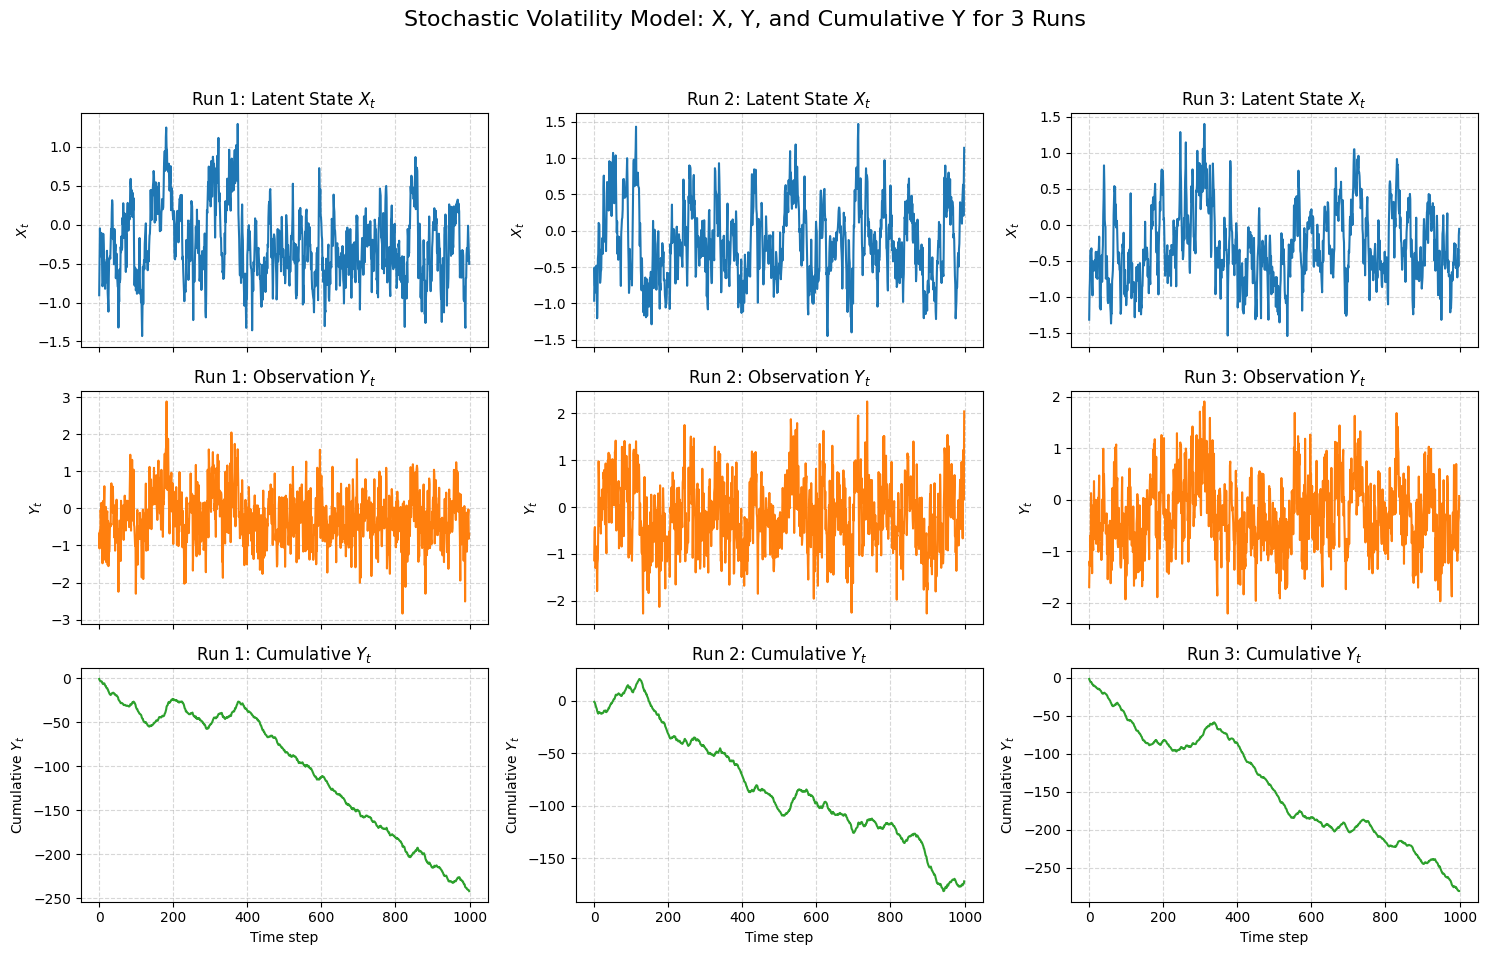

In [46]:
# import matplotlib.pyplot as plt

# plot_key = jax.random.key(100)
# X, Y = stoch_vol_vehicle.generate_data(plot_key, 3, 1000, X_BAR)

# fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)
# fig.suptitle("Stochastic Volatility Model: X, Y, and Cumulative Y for 3 Runs", fontsize=16)

# for i in range(3):
#     # Plot X
#     axes[0, i].plot(X[i], color='tab:blue')
#     axes[0, i].set_title(f"Run {i+1}: Latent State $X_t$")
#     axes[0, i].set_ylabel("$X_t$")
#     axes[0, i].grid(True, linestyle='--', alpha=0.5)
    
#     # Plot Y
#     axes[1, i].plot(Y[i], color='tab:orange')
#     axes[1, i].set_title(f"Run {i+1}: Observation $Y_t$")
#     axes[1, i].set_ylabel("$Y_t$")
#     axes[1, i].grid(True, linestyle='--', alpha=0.5)
    
#     # Plot cumulative Y
#     axes[2, i].plot(jnp.cumsum(Y[i]), color='tab:green')
#     axes[2, i].set_title(f"Run {i+1}: Cumulative $Y_t$")
#     axes[2, i].set_xlabel("Time step")
#     axes[2, i].set_ylabel("Cumulative $Y_t$")
#     axes[2, i].grid(True, linestyle='--', alpha=0.5)

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()


# Training the models.


Training model 1/1: n_layers=1, hidden_dim=64


  0%|          | 0/2500 [00:00<?, ?it/s]

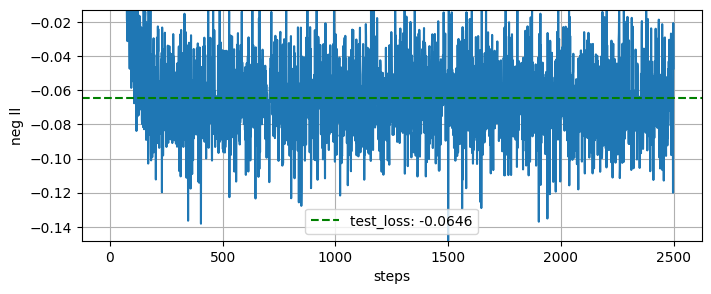

In [47]:
# Training the Feed Forward Network.

trained_models_evals = {}

for i, (n_layers, hidden_dim) in enumerate(MODEL_SIZES):
    print(f"\nTraining model {i+1}/{len(MODEL_SIZES)}: n_layers={n_layers}, hidden_dim={hidden_dim}")
    
    model = FeedForwardNetwork(n_layers, hidden_dim, jax.random.key(100 + i))
    stoch_vol_vehicle.train_model(
        TRAIN_KEY, 
        model,
        TRAIN_BATCH_SIZE, 
        learning_rate=1e-3,
        steps = TRAIN_STEPS, 
        X_bar = X_BAR,
    )

    model_eval = loss(stoch_vol_vehicle.unvectorized_model, test_inputs, test_targets)
    trained_models_evals[(n_layers, hidden_dim)] = model_eval


In [ ]:
print('Bootstrap model eval: ', boot_eval)
print('NNP model eval: ', model_eval)
print('Optimal model eval: ', optimal_eval)

## Model had been trained. 

We now need to run the particle filter.

In [48]:
qq_particle_filter = stoch_vol_vehicle.build_NN_particle_filter(
    include_all_weights=True
)

# 1. Generate the data to run the particle filter on. 

N_RUNS = 2
N_TIMESTEPS = 1000
N_PARTICLES = 2500

DATA_KEY = jax.random.key(65)
EVAL_KEY = jax.random.key(56)


# 1. Use the stochastic volatility vehicle to generate batched data 

print(f"Generating {N_RUNS} runs of data with {N_TIMESTEPS} timesteps each...")
x_vals, y_vals = stoch_vol_vehicle.generate_data(
    DATA_KEY, 
    N_RUNS,
    N_TIMESTEPS,
    X_BAR
)

INIT_PARTICLE_KEY = jax.random.key(16)
initial_particles = jax.random.normal(INIT_PARTICLE_KEY, (N_PARTICLES,)) * 0.1 + X_BAR
initial_log_weights = jnp.zeros(N_PARTICLES) - jnp.log(N_PARTICLES)

# 2. Run the particle filter, unpacking the outputs.

print("Running bootstrap particle filter simulations...")
_, _, bootstrap_diagnostics, output_particles_and_weights = jax.vmap(qq_particle_filter.simulate, in_axes=(0, None, None, 0, 0))(
    jax.random.split(EVAL_KEY, N_RUNS), 
    initial_particles, 
    initial_log_weights, 
    y_vals, 
    x_vals
)


Generating 2 runs of data with 1000 timesteps each...
Running bootstrap particle filter simulations...


In [49]:
print(output_particles_and_weights[0][0].shape)
print(output_particles_and_weights[1][0][2])

(1000, 2500)
[0.00028635 0.00056759 0.00029533 ... 0.00023403 0.00111745 0.00026656]


Now that we have evaluated the particle filter we should begin writing the QQ-plot function

In [90]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def create_qq_plot(output_particles_and_weights, x_vals, y_vals, point_to_plot):

    
    # 1. Unpack the particles and weights.
    particles, weights = output_particles_and_weights
    particles, weights = particles.at[point_to_plot].get(), weights.at[point_to_plot].get()
    particles, weights = np.array(particles), np.array(weights)

    
    x_vals = np.array(x_vals)
    prev_x = x_vals[point_to_plot - 1]
    true_x = x_vals[point_to_plot]
    
    # 2. Prepare for QQ-plot.
    quantiles_to_take = np.linspace(0, 1, 100)
    quantiles_of_interest = np.quantile(particles, quantiles_to_take, axis=0, method='inverted_cdf', weights=weights)

    # 3. True distribution. 
    # Bootstrap
    true_mean, true_std = f_mean_func(prev_x), f_std_func(prev_x)
    true_quantiles = stats.norm.ppf(quantiles_to_take, true_mean, true_std)
    
    # Optimal
    optimal_mean = optimal_mean_func(prev_x, y_vals[point_to_plot+1])
    optimal_std = optimal_std_func(prev_x, y_vals[point_to_plot+1])
    optimal_quantiles = stats.norm.ppf(quantiles_to_take, optimal_mean, optimal_std)
    
    # 4. Make the plot
    fig, axes = plt.subplots(1, 3, figsize=(22, 6))

    # Subplot 1: QQ plot (Bootstrap)
    axes[0].plot(quantiles_of_interest, true_quantiles, marker='o', linestyle='', label='Particle Quantiles')
    axes[0].plot(true_quantiles, true_quantiles, 'k--', label='y=x (Ideal)')
    # Add the true_x as a red star on the QQ plot
    # Find the quantile of true_x in the true distribution
    true_x_quantile = stats.norm.cdf(true_x, loc=true_mean, scale=true_std)
    # Find the corresponding quantile in the particle filter
    # Interpolate the quantile of true_x in the particle filter quantiles
    pf_quantile = np.quantile(particles, true_x_quantile, method='inverted_cdf', weights=weights)
    axes[0].plot(pf_quantile, stats.norm.ppf(true_x_quantile, true_mean, true_std), 'r*', markersize=15, label='True $x_t$')
    axes[0].set_title(f'QQ Plot (Bootstrap) at t={point_to_plot}')
    axes[0].set_xlabel('NNP Proposals Quantiles')
    axes[0].set_ylabel('Bootstrap Quantiles')
    axes[0].legend()
    axes[0].grid(True)

    # Subplot 2: QQ plot (Optimal)
    axes[1].plot(quantiles_of_interest, optimal_quantiles, marker='o', linestyle='', label='Particle Quantiles')
    axes[1].plot(optimal_quantiles, optimal_quantiles, 'k--', label='y=x (Ideal)')
    # Add the true_x as a red star on the QQ plot
    optimal_x_quantile = stats.norm.cdf(true_x, loc=optimal_mean, scale=optimal_std)
    pf_quantile_opt = np.quantile(particles, optimal_x_quantile, method='inverted_cdf', weights=weights)
    axes[1].plot(pf_quantile_opt, stats.norm.ppf(optimal_x_quantile, optimal_mean, optimal_std), 'r*', markersize=15, label='True $x_t$')
    axes[1].set_title(f'QQ Plot (Optimal) at t={point_to_plot}')
    axes[1].set_xlabel('NNP Proposals Quantiles')
    axes[1].set_ylabel('Optimal Quantiles')
    axes[1].legend()
    axes[1].grid(True)

    # Subplot 3: Cumulative sorted weight function
    sorted_indices = np.argsort(weights)
    sorted_weights = weights[sorted_indices]
    cum_weights = np.cumsum(sorted_weights)
    cum_weights /= cum_weights[-1]  # Normalize to 1

    axes[2].plot(cum_weights, label='Cumulative Weight')
    axes[2].set_title(f'Cumulative Sorted Weight Function at t={point_to_plot}')
    axes[2].set_xlabel('Particle Value')
    axes[2].set_ylabel('Cumulative Weight')
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

In [88]:
all_particles, all_weights = output_particles_and_weights
first_particles, first_weights = all_particles[0], all_weights[0]

print(first_weights.shape)
print(first_particles.shape)

(1000, 2500)
(1000, 2500)


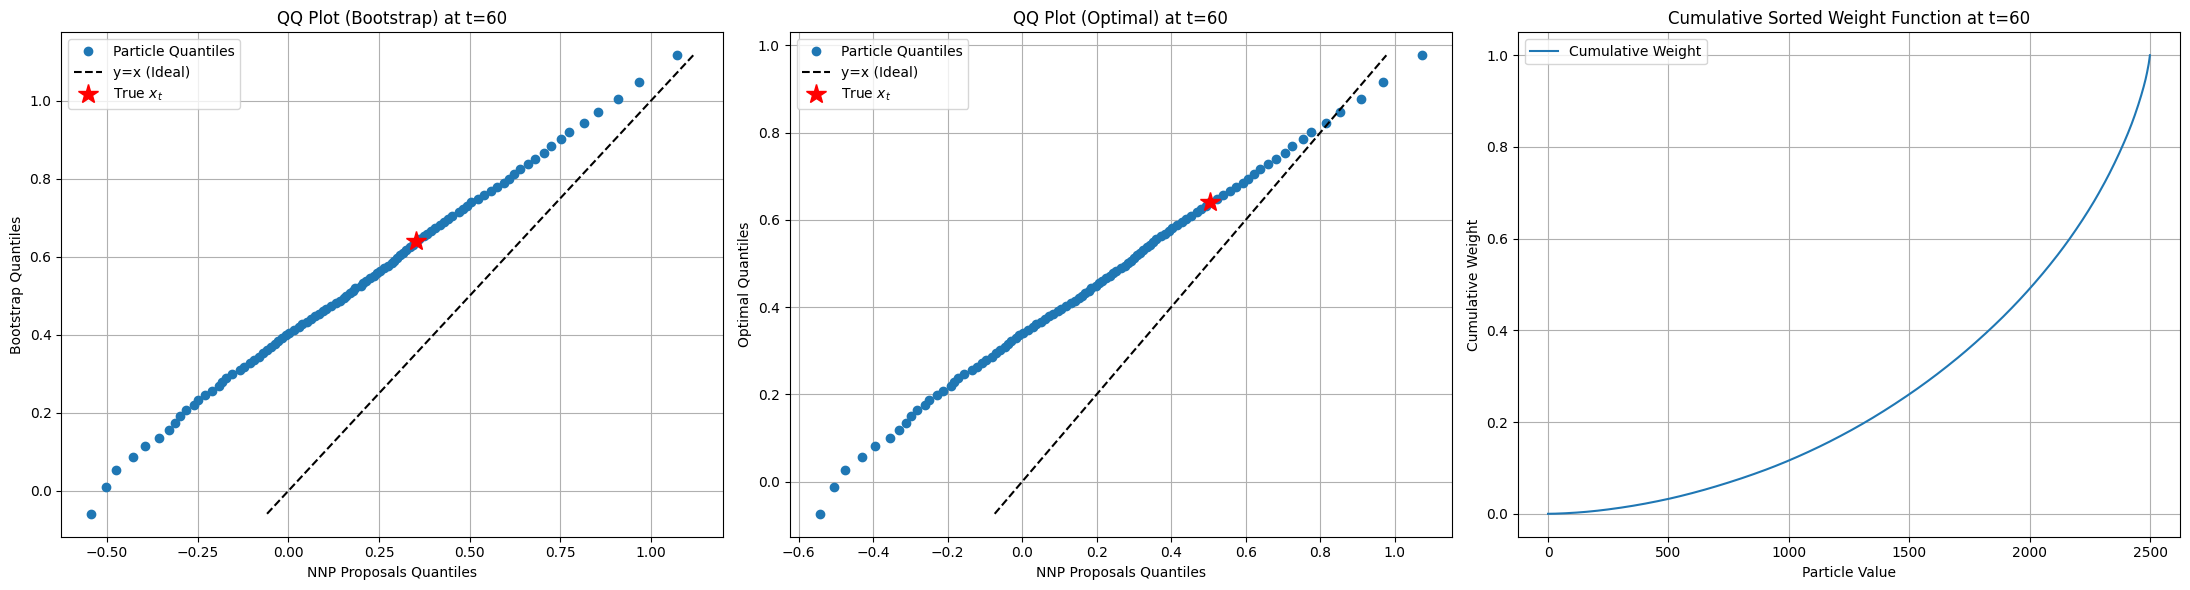

In [94]:
create_qq_plot((first_particles, first_weights), x_vals[0], y_vals[0], 60)

In [53]:
print(output_particles_and_weights[0].shape)

(2, 1000, 2500)


In [86]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def animate_qq_plot(output_particles_and_weights, x_vals, y_vals, t_range=None, interval=500, save_path=None):
    """
    Animate the QQ plot (both Bootstrap and Optimal) and cumulative weight plot over time.

    Args:
        output_particles_and_weights: tuple of (all_particles, all_weights)
        x_vals: true x values (array-like)
        y_vals: observed y values (array-like)
        t_range: iterable of time indices to animate over (default: all valid)
        interval: delay between frames in ms
        save_path: if not None, path to save the animation (e.g. 'qq_animation.mp4')
    """
    all_particles, all_weights = output_particles_and_weights
    all_particles = np.array(all_particles)
    all_weights = np.array(all_weights)
    x_vals = np.array(x_vals)
    y_vals = np.array(y_vals)

    if t_range is None:
        # By default, animate over all time points except the first (since prev_x = x_vals[t-1])
        t_range = range(1, min(len(x_vals), all_particles.shape[0]) - 1)  # -1 to avoid index error for y_vals[point_to_plot+1]

    quantiles_to_take = np.linspace(0, 1, 100)

    fig, axes = plt.subplots(1, 3, figsize=(22, 6))

    # Set up empty plots for Bootstrap QQ
    qq_line_bootstrap, = axes[0].plot([], [], marker='o', linestyle='', label='Particle Quantiles')
    ideal_line_bootstrap, = axes[0].plot([], [], 'k--', label='y=x (Ideal)')
    true_x_star_bootstrap, = axes[0].plot([], [], 'r*', markersize=15, label='True $x_t$')

    # Set up empty plots for Optimal QQ
    qq_line_optimal, = axes[1].plot([], [], marker='o', linestyle='', label='Particle Quantiles')
    ideal_line_optimal, = axes[1].plot([], [], 'k--', label='y=x (Ideal)')
    true_x_star_optimal, = axes[1].plot([], [], 'r*', markersize=15, label='True $x_t$')

    # Cumulative weight plot
    cum_weight_line, = axes[2].plot([], [], label='Cumulative Weight')

    def init():
        # Bootstrap QQ
        axes[0].set_xlabel('NNP Proposals Quantiles')
        axes[0].set_ylabel('Bootstrap Quantiles')
        axes[0].legend()
        axes[0].grid(True)
        # Optimal QQ
        axes[1].set_xlabel('NNP Proposals Quantiles')
        axes[1].set_ylabel('Optimal Quantiles')
        axes[1].legend()
        axes[1].grid(True)
        # Cumulative
        axes[2].set_xlabel('Particle Value')
        axes[2].set_ylabel('Cumulative Weight')
        axes[2].legend()
        axes[2].grid(True)
        return (qq_line_bootstrap, ideal_line_bootstrap, true_x_star_bootstrap,
                qq_line_optimal, ideal_line_optimal, true_x_star_optimal,
                cum_weight_line)

    def update(frame):
        point_to_plot = t_range[frame]
        particles = all_particles[point_to_plot]
        weights = all_weights[point_to_plot]
        prev_x = x_vals[point_to_plot - 1]
        true_x = x_vals[point_to_plot]

        # --- Bootstrap QQ plot ---
        quantiles_of_interest = np.quantile(particles, quantiles_to_take, axis=0, method='inverted_cdf', weights=weights)
        true_mean, true_std = f_mean_func(prev_x), f_std_func(prev_x)
        true_quantiles = stats.norm.ppf(quantiles_to_take, true_mean, true_std)

        # Swap axes: proposal quantile (quantiles_of_interest) on x, true quantile on y
        qq_line_bootstrap.set_data(quantiles_of_interest, true_quantiles)
        ideal_line_bootstrap.set_data(quantiles_of_interest, quantiles_of_interest)

        # True x star for Bootstrap
        true_x_quantile = stats.norm.cdf(true_x, loc=true_mean, scale=true_std)
        pf_quantile = np.quantile(particles, true_x_quantile, method='inverted_cdf', weights=weights)
        # Swap axes for the star as well
        true_x_star_bootstrap.set_data([pf_quantile], [stats.norm.ppf(true_x_quantile, true_mean, true_std)])

        axes[0].set_title(f'QQ Plot (Bootstrap) at t={point_to_plot}')
        axes[0].relim()
        axes[0].autoscale_view()

        # --- Optimal QQ plot ---
        # Defensive: check if point_to_plot+1 is in bounds for y_vals
        if point_to_plot + 1 < len(y_vals):
            optimal_mean = optimal_mean_func(prev_x, y_vals[point_to_plot+1])
            optimal_std = optimal_std_func(prev_x, y_vals[point_to_plot+1])
        else:
            # Fallback: use last available y_val
            optimal_mean = optimal_mean_func(prev_x, y_vals[-1])
            optimal_std = optimal_std_func(prev_x, y_vals[-1])
        optimal_quantiles = stats.norm.ppf(quantiles_to_take, optimal_mean, optimal_std)

        # Swap axes: proposal quantile (quantiles_of_interest) on x, optimal quantile on y
        qq_line_optimal.set_data(quantiles_of_interest, optimal_quantiles)
        ideal_line_optimal.set_data(quantiles_of_interest, quantiles_of_interest)

        # True x star for Optimal
        optimal_x_quantile = stats.norm.cdf(true_x, loc=optimal_mean, scale=optimal_std)
        pf_quantile_opt = np.quantile(particles, optimal_x_quantile, method='inverted_cdf', weights=weights)
        # Swap axes for the star as well
        true_x_star_optimal.set_data([pf_quantile_opt], [stats.norm.ppf(optimal_x_quantile, optimal_mean, optimal_std)])

        axes[1].set_title(f'QQ Plot (Optimal) at t={point_to_plot}')
        axes[1].relim()
        axes[1].autoscale_view()

        # --- Cumulative sorted weight function ---
        sorted_indices = np.argsort(particles)
        sorted_particles = particles[sorted_indices]
        sorted_weights = weights[sorted_indices]
        cum_weights = np.cumsum(sorted_weights)
        cum_weights /= cum_weights[-1]  # Normalize to 1

        cum_weight_line.set_data(sorted_particles, cum_weights)
        axes[2].set_title(f'Cumulative Sorted Weight Function at t={point_to_plot}')
        axes[2].set_xlim(np.min(sorted_particles), np.max(sorted_particles))
        axes[2].set_ylim(0, 1.05)
        axes[2].relim()
        axes[2].autoscale_view()

        return (qq_line_bootstrap, ideal_line_bootstrap, true_x_star_bootstrap,
                qq_line_optimal, ideal_line_optimal, true_x_star_optimal,
                cum_weight_line)

    anim = FuncAnimation(
        fig, update, frames=len(t_range), init_func=init, blit=False, interval=interval, repeat=True
    )

    plt.tight_layout()
    if save_path is not None:
        # Guidance: To save an animation with matplotlib, the file extension should be .gif (for PillowWriter) or .mp4 (for ffmpeg, if available).
        # If you get an error with .mp4, try using .gif instead, e.g. save_path='qq_animation.gif'
        # Example:
        # anim.save('qq_animation.gif', writer='pillow')
        # anim.save('qq_animation.mp4', writer='ffmpeg')
        # If unsure, .gif is the most universally supported.
        if save_path.lower().endswith('.gif'):
            anim.save(save_path, writer='pillow')
        elif save_path.lower().endswith('.mp4'):
            try:
                anim.save(save_path, writer='ffmpeg')
            except Exception as e:
                print("ffmpeg not available or error saving as mp4. Try saving as .gif instead.")
                raise e
        else:
            raise ValueError("Unknown file extension for animation. Use '.gif' (recommended) or '.mp4'.")
    else:
        plt.show()


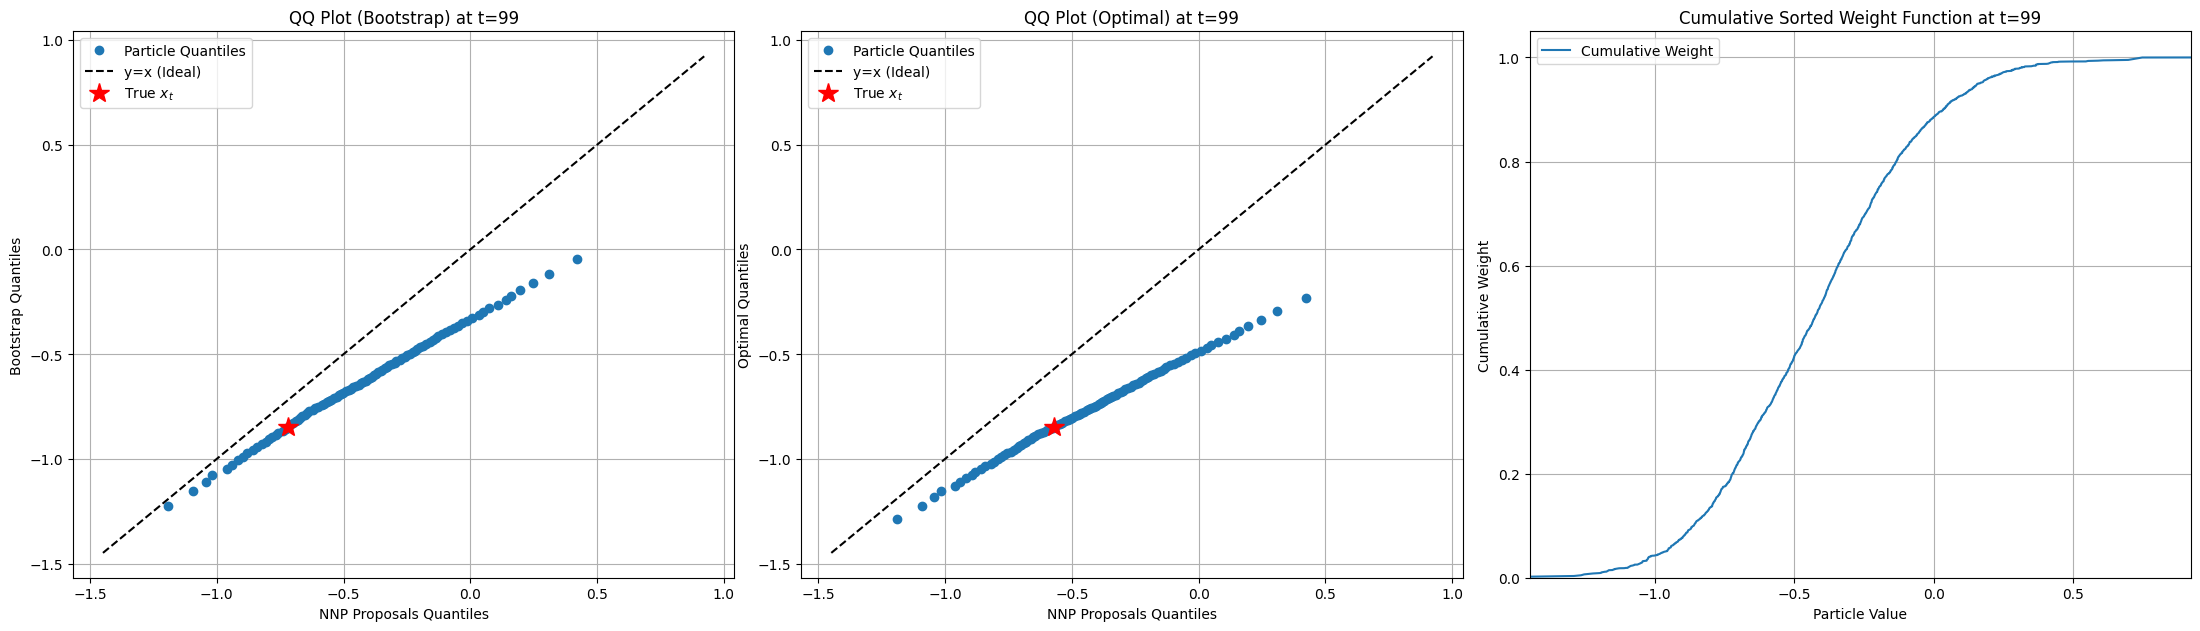

In [87]:
animate_qq_plot((first_particles, first_weights), x_vals[0], y_vals[0], range(1, 100), interval=100, save_path='qq_animation_2.gif')